## Prerequesites

### Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp


### Plotting Style Setting

In [2]:
sb.set(rc={"figure.figsize": (12, 8)})


## Data Acquisition and Cleanup

In [3]:
raw = pd.read_json("https://api.covidtracking.com/v1/states/wi/daily.json")
backup = raw


In [4]:
# https://www.census.gov/quickfacts/WI
population = 5822434


In [5]:
def data_cleanup(data):
    data.sort_values("date", inplace=True)
    data.fillna(0, inplace=True)
    data.loc[:, ["date"]] = pd.to_datetime(data["date"], format="%Y%m%d")
    data.loc[:, ["daysFromStart"]] = data["date"] - data.iloc[0]["date"]
    data.loc[:, ["daysFromStart"]] = data["daysFromStart"].dt.days
    data.set_index("daysFromStart", inplace=True)
    # data = data.select_dtypes(exclude=object)

data_cleanup(raw)
raw


,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
daysFromStart,,,,,,,,,,,,,,,,,,,,,
0,2020-03-03,WI,0.0,0.0,0.0,0.0,totalTestEncountersViral,7,0.0,0.0,...,0.0,0,0,396b459dd3e046fa988c52d20decb73e17d331fc,0,0,0,0,0,
1,2020-03-04,WI,1.0,0.0,19.0,6.0,totalTestEncountersViral,7,0.0,0.0,...,0.0,0,0,23d37d633a3defa3160d79b737662faf54c711f0,0,0,0,0,0,
2,2020-03-05,WI,1.0,0.0,19.0,6.0,totalTestEncountersViral,12,0.0,0.0,...,0.0,0,0,0a683a837943b722a37d85e43f37e43d15903c6c,0,0,0,0,0,
3,2020-03-06,WI,1.0,0.0,31.0,12.0,totalTestEncountersViral,21,0.0,0.0,...,0.0,0,0,e87a35e9bf59d2c731263612cd9832a34b0b9668,0,0,0,0,0,
4,2020-03-07,WI,1.0,0.0,31.0,12.0,totalTestEncountersViral,31,0.0,0.0,...,0.0,0,0,078f703acb259e3899af0d99a5d3e41d41848795,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,2021-03-03,WI,619087.0,53956.0,2634999.0,36.0,totalTestEncountersViral,6970553,267.0,26279.0,...,0.0,19,57,2d03e79d7cda7217e2fc625a15d4bfbedc6fd643,0,0,0,0,0,
366,2021-03-04,WI,619942.0,54134.0,2639148.0,19.0,totalTestEncountersViral,7008539,262.0,26330.0,...,0.0,13,51,113b3d81b402d0025b4eac17dbafb840c83b974c,0,0,0,0,0,
367,2021-03-05,WI,620663.0,54505.0,2642182.0,36.0,totalTestEncountersViral,7037081,260.0,26387.0,...,0.0,12,57,95b2a8208a870ba9b97f9f6afe29999c147f011e,0,0,0,0,0,


## Data Extraction

In [6]:
def extract_data(raw):
    # https://covidtracking.com/about-data/data-definitions
    global population
    data = pd.DataFrame(raw[["date"]])
    data["susceptible"] = population - raw["positiveCasesViral"]
    data["infectious"] = raw["positiveCasesViral"] - raw["recovered"] - raw["deathConfirmed"]
    data["recovered"] = raw["recovered"]
    data["deceased"] = raw["deathConfirmed"]
    for col in ["susceptible", "infectious", "recovered", "deceased"]:
        data.loc[:, col] = data[col].astype(int)
    return data

data = extract_data(raw)
data


,date,susceptible,infectious,recovered,deceased
daysFromStart,,,,,
0,2020-03-03,5822434,0,0,0
1,2020-03-04,5822433,1,0,0
2,2020-03-05,5822433,1,0,0
3,2020-03-06,5822433,1,0,0
4,2020-03-07,5822433,1,0,0
...,...,...,...,...,...
365,2021-03-03,5257303,7344,551329,6458
366,2021-03-04,5256626,7453,551885,6470
367,2021-03-05,5256276,7370,552311,6477


## Exploratory Data Analysis

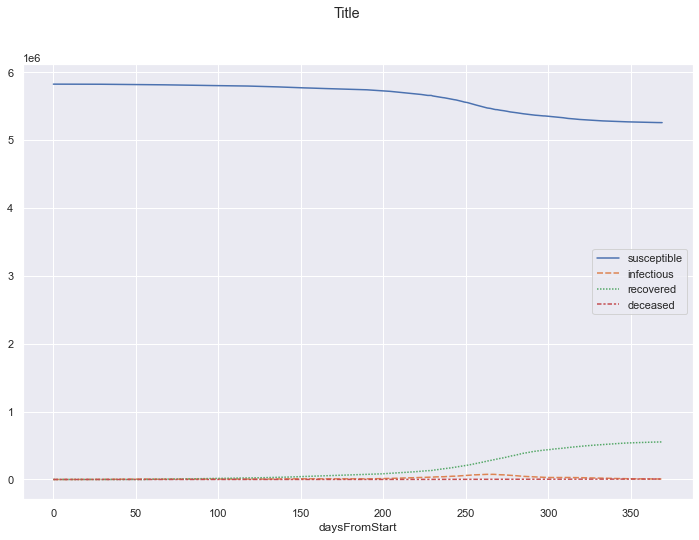

In [7]:
plt.suptitle("Title")
sb.lineplot(data=data)
plt.show()


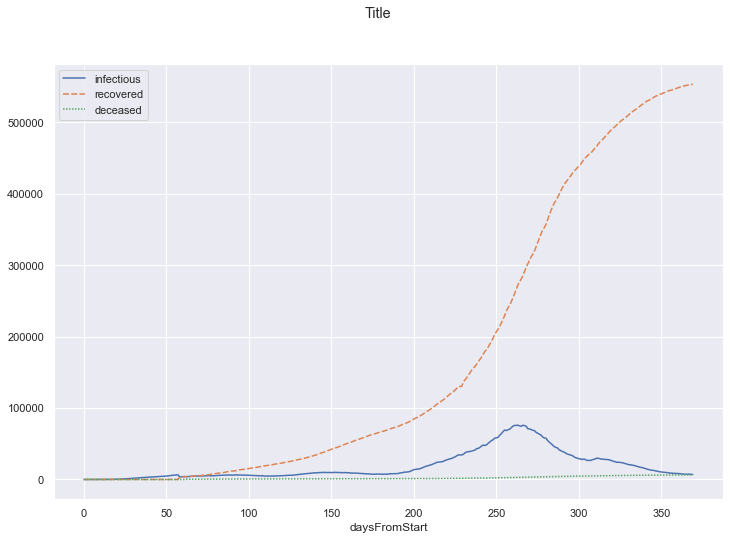

In [8]:
plt.suptitle("Title")
sb.lineplot(data=data[["infectious", "recovered", "deceased"]])
plt.show()


## Data Preparation

In [9]:
def filter_data(data, start=None, end=None):
    filtered = data.reset_index().sort_values("date")
    if start: filtered = filtered[filtered["date"] >= start]
    if end: filtered = filtered[filtered["date"] < end]
    filtered.loc[:, "daysFromStart"] -= filtered.iloc[0]["daysFromStart"]
    filtered.set_index("daysFromStart", inplace=True)
    return filtered

data1 = filter_data(data, start=datetime(2020, 5, 4), end=datetime(2020, 11, 20))
data1


,date,susceptible,infectious,recovered,deceased
daysFromStart,,,,,
0,2020-05-04,5814198,3923,3973,340
1,2020-05-05,5813868,4082,4131,353
2,2020-05-06,5813533,4191,4348,362
3,2020-05-07,5813219,4321,4520,374
4,2020-05-08,5812844,4512,4694,384
...,...,...,...,...,...
195,2020-11-15,5510065,69657,240075,2637
196,2020-11-16,5505676,70268,243841,2649
197,2020-11-17,5498586,72407,248700,2741


In [10]:
def get_SIRD_vars(data):
    t = data.index.to_numpy()
    arr = data.to_numpy()
    _, S, I, R, D = arr.T
    return t, S, I, R, D

t1, S1, I1, R1, D1 = get_SIRD_vars(data1)
y1 = np.column_stack((S1, I1, R1, D1))
y1.shape


(200, 4)

The SIRD model:

$\begin{equation}
\begin{split}
\frac{dS}{dt} & = - \frac{\beta I S}{N}, \\
\frac{dI}{dt} & = \frac{\beta I S}{N} - \gamma I - \mu I, \\
\frac{dR}{dt} & = \gamma I, \\
\frac{dD}{dt} & = \mu I.
\end{split}
\end{equation}$


## Machine Learning

In [11]:
def SIRD(t, y, beta, gamma, mu):
    global population
    N = population
    S, I, R, D = y
    dS_dt = - beta * I * S / N
    dI_dt =   beta * I * S / N - gamma * I - mu * I
    dR_dt =   gamma * I
    dD_dt =   mu * I
    return (dS_dt, dI_dt, dR_dt, dD_dt)


In [12]:
def loss(k, t, y):
    from IPython.display import clear_output
    global iter_
    beta, gamma, mu = k
    S, I, R, D = y.T
    sol = solve_ivp(fun=SIRD, t_span=(t[0], t[-1]), y0=y[0], t_eval=t, dense_output=True, args=k)
    S_sol, I_sol, R_sol, D_sol = sol.y
    mse = np.sum((S_sol - S) ** 2 + (I_sol - I) ** 2 + (R_sol - R) ** 2 + (D_sol - D) ** 2) / len(t)
    iter_ += 1
    print(f"Iteration #{'%4d' % iter_}: MSE = {mse}")
    clear_output(wait=True)
    return mse

def fit_model(t, y):
    from scipy.optimize import minimize
    # from scipy.optimize import differential_evolution
    # from scipy.optimize import least_squares
    # from scipy.optimize import curve_fit
    def SIRD_int(t, beta, gamma, mu):
        return solve_ivp(fun=SIRD, t_span=(t[0], t[-1]), y0=y[0], t_eval=t, args=(beta, gamma, mu)).y.flatten()
        # https://stackoverflow.com/questions/51522103/valueerror-object-too-deep-for-desired-array-in-optimize-curve-fit

    S, I, R, D = y.T
    x0 = (0.1, 0.1, 0.01)
    bounds = ((1e-4, 0.3), (1e-4, 0.3), (1e-4, 0.1))  # bounds for beta, gamma, and mu
    # bounds = ((1e-4, 1e-4, 1e-4), (0.2, 0.2, 0.1))  # bounds for beta, gamma, and mu
    return minimize(fun=loss, x0=x0, args=(t, y), bounds=bounds, method="Nelder-Mead")
    # return differential_evolution(func=loss, bounds=bounds, args=(t, y))
    # return least_squares(fun=loss, x0=x0, bounds=bounds, max_nfev=1e5)
    # return curve_fit(f=SIRD_int, xdata=t, ydata=y.flatten(), method="lm")
    # return minimize(fun=loss, x0=x0, args=(t, y), bounds=bounds, method="Powell")


In [13]:
class fit_res:
    """A collection of SIRD fitting results."""

    def __init__(self, t, y):
        global iter_
        iter_ = 0
        self.t = t
        self.y = y
        self.fit = fit_model(t, y)
        self.iter = iter_
        self.mse = self.fit.fun
    
    def __repr__(self):
        return str(f"Fitting completed within {self.iter} iterations.\n" \
                #    f"           MSE: {self.mse}\n" \
                   f"{self.fit}")


In [14]:
res1 = fit_res(t1, y1)
res1


Fitting completed within 320 iterations.
 final_simplex: (array([[ 0.06285865,  0.04802755, -0.00046076],
       [ 0.06285866,  0.04802756, -0.00046076],
       [ 0.06285865,  0.04802755, -0.00046076],
       [ 0.06285865,  0.04802755, -0.00046076]]), array([2.94691793e+08, 2.94691793e+08, 2.94691793e+08, 2.94691793e+08]))
           fun: 294691792.5754909
       message: 'Optimization terminated successfully.'
          nfev: 320
           nit: 175
        status: 0
       success: True
             x: array([ 0.06285865,  0.04802755, -0.00046076])

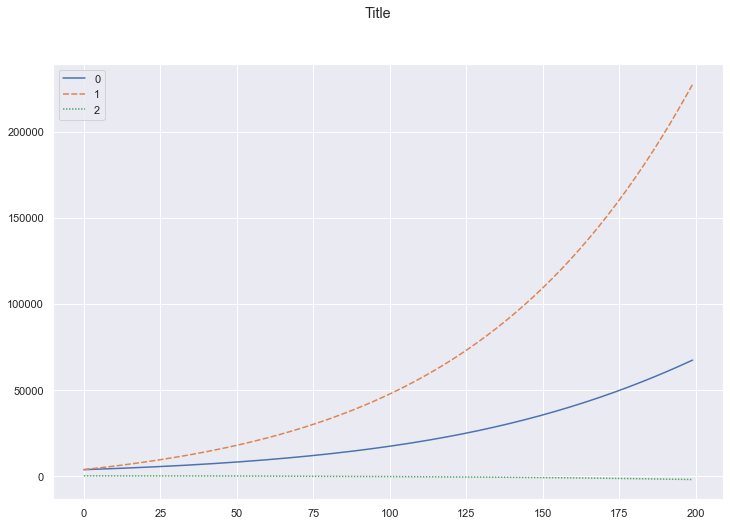

In [15]:
y1_res = np.array(solve_ivp(fun=SIRD, t_span=(res1.t[0], res1.t[-1]), y0=res1.y[0], t_eval=res1.t, dense_output=True, args=(res1.fit.x)).y).T
plt.suptitle("Title")
sb.lineplot(data=y1_res.T[1:].T)
plt.show()


In [16]:
def fit(data, start=None, end=None):
    filtered = filter_data(data, start, end)
    t, S, I, R, D = get_SIRD_vars(filtered)
    y = np.column_stack((S, I, R, D))
    res = fit_res(t, y)
    return res


In [17]:
res2 = fit(data, start=datetime(2020, 11, 20))


Iteration # 228: MSE = 36340301.04476978


In [18]:
res2


Fitting completed within 228 iterations.
 final_simplex: (array([[0.07019502, 0.08304489, 0.00069931],
       [0.07019502, 0.08304489, 0.00069932],
       [0.07019502, 0.08304489, 0.00069932],
       [0.070195  , 0.08304487, 0.00069932]]), array([36340301.04475875, 36340301.04476978, 36340301.04482715,
       36340301.04484559]))
           fun: 36340301.04475875
       message: 'Optimization terminated successfully.'
          nfev: 228
           nit: 128
        status: 0
       success: True
             x: array([0.07019502, 0.08304489, 0.00069931])

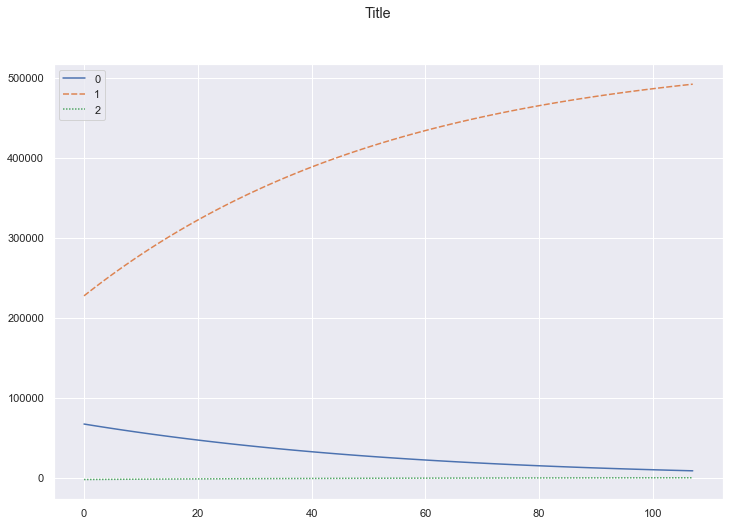

In [19]:
y2_res = np.array(solve_ivp(fun=SIRD, t_span=(res2.t[0], res2.t[-1]), y0=y1_res[-1], t_eval=res2.t, dense_output=True, args=(res2.fit.x)).y).T
plt.suptitle("Title")
sb.lineplot(data=y2_res.T[1:].T)
plt.show()


In [20]:
y_res = np.concatenate([y1_res, y2_res])
y_res.shape


(308, 4)

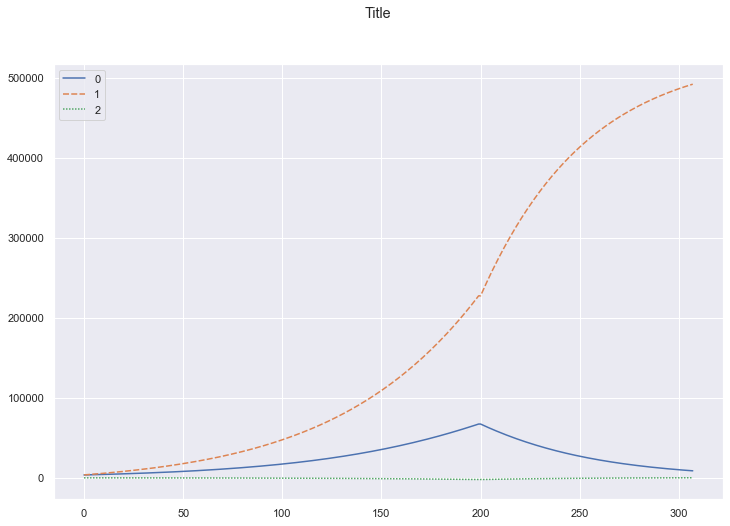

In [21]:
plt.suptitle("Title")
sb.lineplot(data=y_res.T[1:].T)
plt.show()


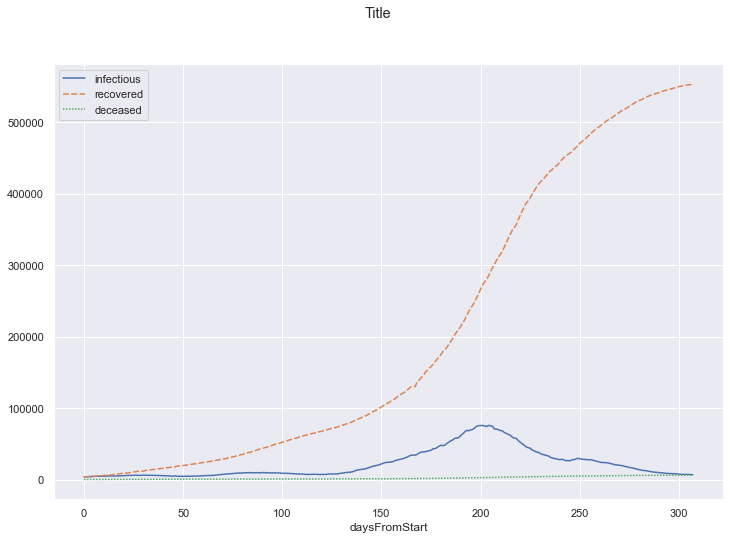

In [22]:
y = filter_data(data, start=datetime(2020, 5, 4))
plt.suptitle("Title")
sb.lineplot(data=y[["infectious", "recovered", "deceased"]])
plt.show()
